# Housing Price prediction Part 1 - Explore the data
### Source
* We use the the Ames Housing dataset in this exercie, which was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 
* Source of data: [Link](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)
### Background
* The final goal is to predict the sale price for each house. For each house ID in the test set, each student in the end must predict the value of the SalePrice variable.
### Metric
Final results are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. 
## Part 1 - Goal:
1. Understand the problem - examine the 76 variables
2. Explain the dependent variable ('SalePrice')
3. Parameter relationships
4. Data cleaning
5. Test assumptions with data visualization
6. Create a Kaggle account and email me

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# load data
df_train = pd.read_csv('./data/train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


* Type - Check variable types and understand the differences
* Segment or Group - by intuition, which one do we expect to be most important.
* Statistics attributes

## 1. The dependent variable

In [5]:
#descriptive statistics summary
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

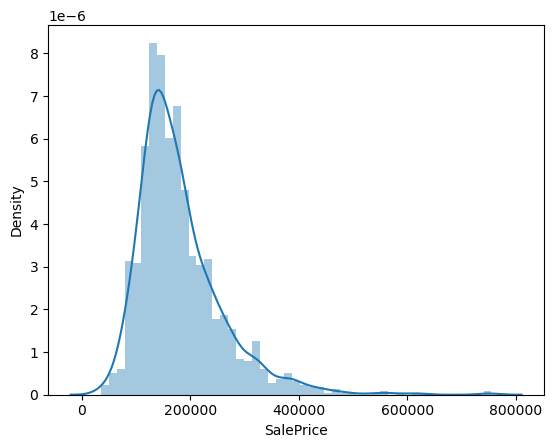

In [6]:
#histogram
sns.distplot(df_train['SalePrice'])

In [7]:
#skewness and kurtosis
# skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean
# kurtosis is a measure of the "tailedness" of the probability distribution of a real-valued random variable
# The kurtosis for a standard normal distribution is three.
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


**distribution measures**

* Skewness measures the asymmetry of the probability distribution of a real-valued random variable about its mean. In simpler terms, it tells you how much a distribution is shifted or "skewed" to the left or right. A skewness value of 0 indicates a perfectly symmetrical distribution.
* Kurtosis measures the "tailedness" of the probability distribution of a real-valued random variable. It describes how heavy the tails of the distribution are compared to a normal distribution. Higher kurtosis values indicate that the distribution has heavier tails and a sharper peak, while lower kurtosis values indicate lighter tails and a flatter peak.
* The Sale Price kurtosis is 6.536. Since a normal distribution has a kurtosis value of 3, this higher value indicates that the Sale Price distribution has heavier tails and a more peaked center than a normal distribution as can be seen in the distribution above.

**Target Variable Summary**:

Our target variable for this problem is the Sale Price of houses. Let's summarize the key insights about this variable:

* There are no records with less than zero. This is expected, as house prices should always be positive.
* The House Sale Price variable is not normally distributed. This is important because certain machine learning algorithms assume that the input data is normally distributed.
* The dataset has a lot of extreme values (outliers) and a very sharp peak. Outliers can significantly impact the performance of our models, so we'll need to address them during preprocessing.
* The distribution of house prices exhibits positive (right-skewed) skewness. This means that the majority of the houses are priced lower than the average, with a few houses having significantly higher prices (outliers).
* The peakedness of the distribution lies between 80,000 and 240,000. This indicates that the majority of the houses fall within this price range.

As we proceed with our analysis, we will keep these characteristics in mind to ensure that our models are able to make accurate predictions. We may need to apply data transformations or outlier removal techniques to better fit the assumptions of our chosen machine learning algorithms.

## 2. Check missing data
* We'll consider that when more than 15% of the data is missing, we should delete the corresponding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases.


In [8]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


In [11]:
missing_data[missing_data['Total'] > 1].index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu',
       'LotFrontage', 'GarageYrBlt', 'GarageCond', 'GarageType',
       'GarageFinish', 'GarageQual', 'BsmtFinType2', 'BsmtExposure',
       'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'MasVnrArea'],
      dtype='object')

In [12]:
#dealing with missing data
# how to set up rules with missing data
df_train = df_train.drop(missing_data[missing_data['Total'] > 1].index, axis = 1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

## 3. Check data type

In [21]:
alltypes = df_train.dtypes.reset_index().rename(columns={0:'type'})
# seperate the numerical and categorical data
numeric = alltypes.loc[alltypes['type'] != 'object']
categorical = alltypes.loc[alltypes['type'] == 'object']
print("Numeric: ", numeric['index'].values)
print("Categorical: ", categorical['index'].values)

Numeric:  ['Id' 'MSSubClass' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath'
 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr'
 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'GarageArea' 'WoodDeckSF'
 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch' 'PoolArea'
 'MiscVal' 'MoSold' 'YrSold' 'SalePrice']
Categorical:  ['MSZoning' 'Street' 'LotShape' 'LandContour' 'Utilities' 'LotConfig'
 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2' 'BldgType'
 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd'
 'ExterQual' 'ExterCond' 'Foundation' 'Heating' 'HeatingQC' 'CentralAir'
 'Electrical' 'KitchenQual' 'Functional' 'PavedDrive' 'SaleType'
 'SaleCondition']


### Randomly plot the relationships

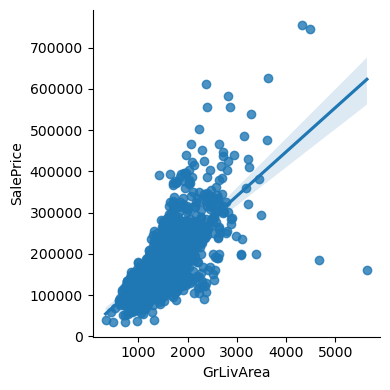

In [26]:
#scatter plot grlivarea/saleprice
fig, ax = plt.subplots(figsize = (4,4))
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
sns.regplot(x=var, y='SalePrice', data=data, ax=ax, fit_reg=True)
sns.despine()
plt.tight_layout()

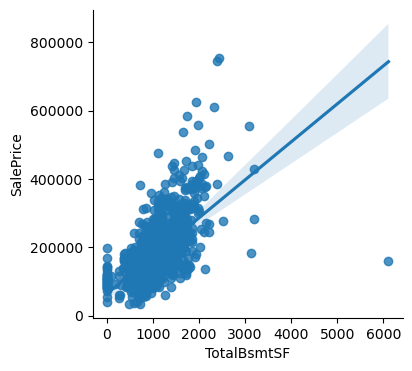

In [28]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
fig, ax = plt.subplots(figsize = (4,4))
sns.regplot(x=var, y='SalePrice', data=data, ax=ax, fit_reg=True)
sns.despine()

In [32]:
# get the p-value of the slope
print("p-value: ", stats.linregress(data[var], data['SalePrice']).pvalue)

# get the slope and intercept of the regression line
print("slope: ", stats.linregress(data[var], data['SalePrice']).slope)

p-value:  7.540001293893559e-152
slope:  111.25720241517892


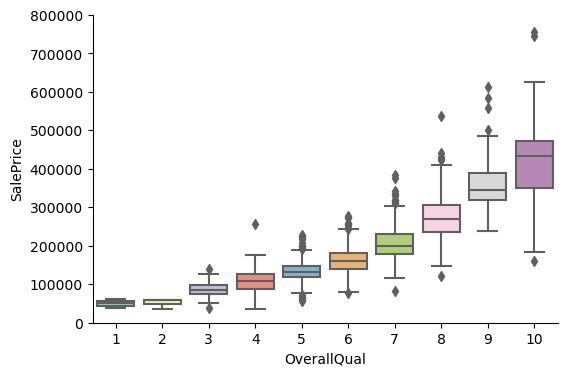

In [37]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(6, 4))
fig = sns.boxplot(x=var, 
                  y="SalePrice", 
                  data=data,
                  palette="Set3"
                  )
fig.axis(ymin=0, ymax=800000)
sns.despine()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 [Text(0, 0, '1872'),
  Text(1, 0, '1875'),
  Text(2, 0, '1880'),
  Text(3, 0, '1882'),
  Text(4, 0, '1885'),
  Text(5, 0, '1890'),
  Text(6, 0, '1892'),
  Text(7, 0, '1893'),
  Text(8, 0, '1898'),
  Text(9, 0, '1900'),
  Text(10, 0, '1904'),
  Text(11, 0, '1905'),
  Text(12, 0, '1906'),
  Text(13, 0, '1908'),
  Text(14, 0, '1910'),
  Text(15, 0, '1911'),
  Text(1

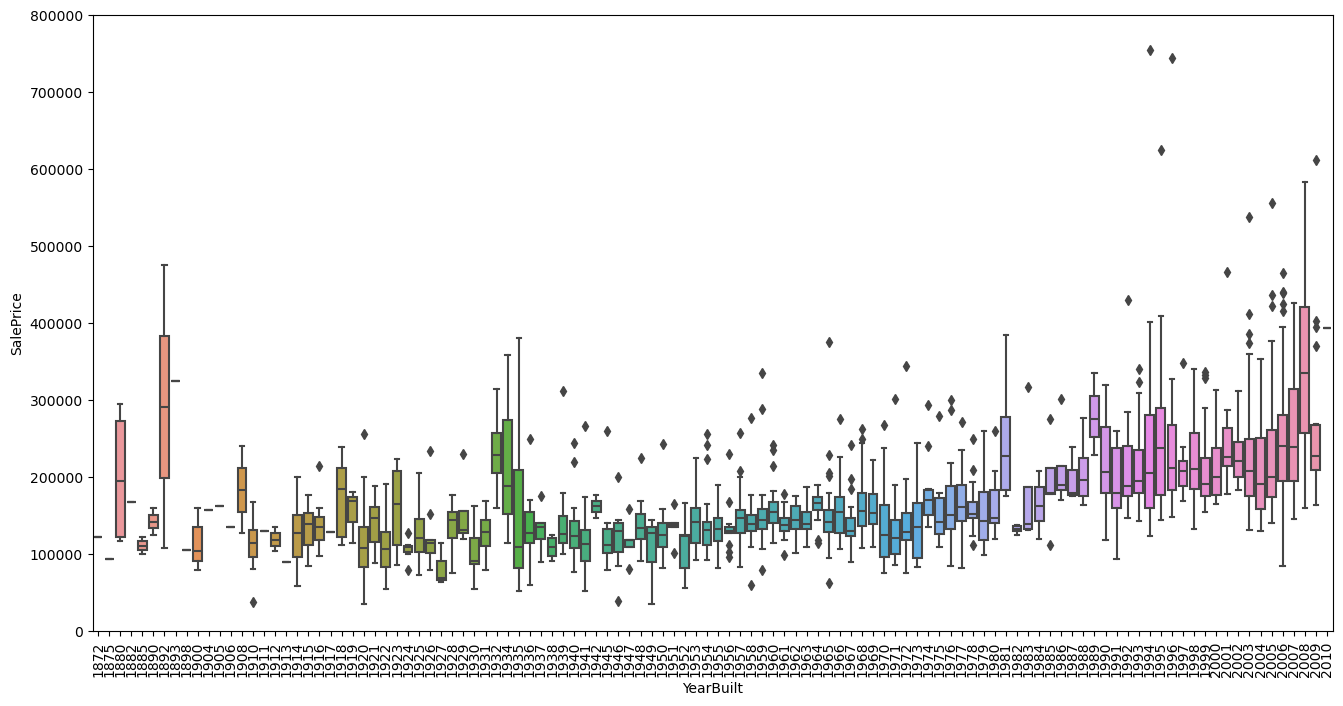

In [38]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90)

([<matplotlib.axis.XTick at 0x18f35d110>,
 [Text(0, 0, '1872'),
  Text(10, 0, '1904'),
  Text(20, 0, '1916'),
  Text(30, 0, '1926'),
  Text(40, 0, '1937'),
  Text(50, 0, '1949'),
  Text(60, 0, '1959'),
  Text(70, 0, '1969'),
  Text(80, 0, '1979'),
  Text(90, 0, '1989'),
  Text(100, 0, '1999'),
  Text(110, 0, '2009')])

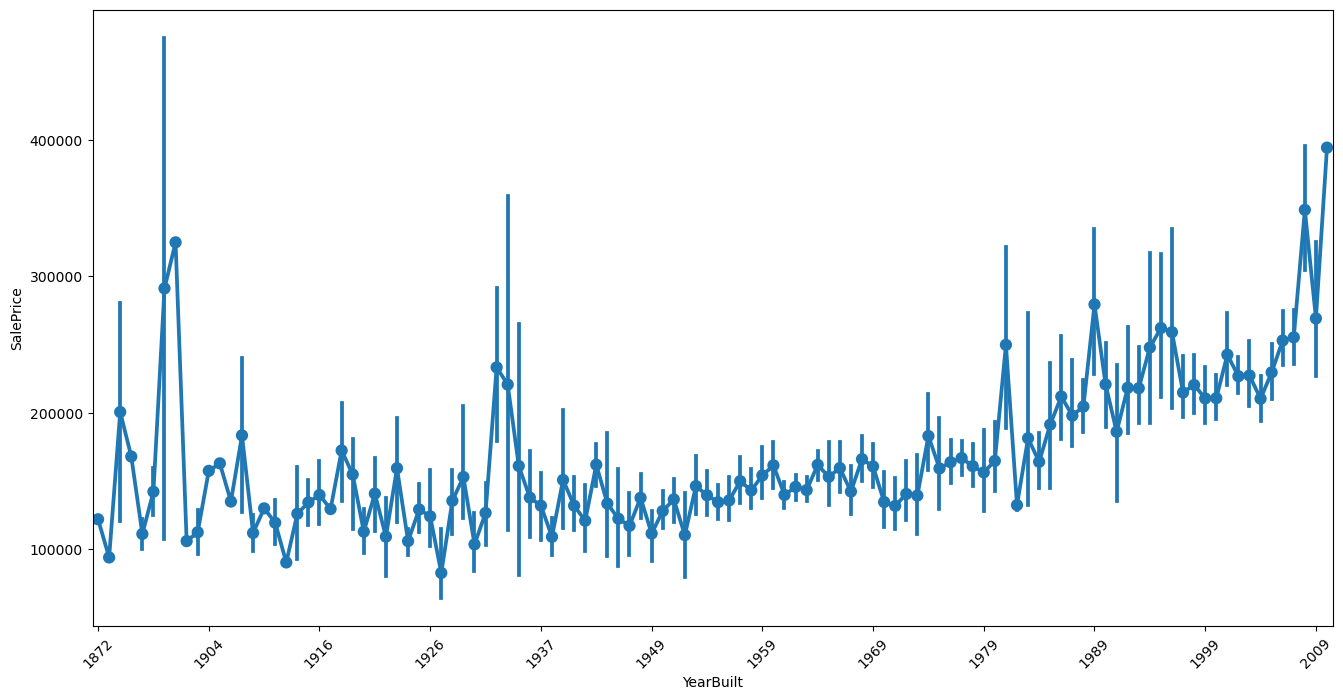

In [41]:
# revise the plot to only show every 10 years
var = 'YearBuilt'
fig, ax = plt.subplots(figsize=(16, 8))
sns.pointplot(x=var, y="SalePrice", data=data, ci=95)
# make the axis only show every 10 years
plt.xticks(np.arange(0, len(data[var].unique()), 10), rotation=45)

([<matplotlib.axis.XTick at 0x190c17f50>,
 [Text(0, 0, '1900'),
  Text(10, 0, '1915'),
  Text(20, 0, '1925'),
  Text(30, 0, '1936'),
  Text(40, 0, '1948'),
  Text(50, 0, '1958'),
  Text(60, 0, '1968'),
  Text(70, 0, '1978'),
  Text(80, 0, '1988'),
  Text(90, 0, '1998'),
  Text(100, 0, '2008'),
  Text(110, 0, '')])

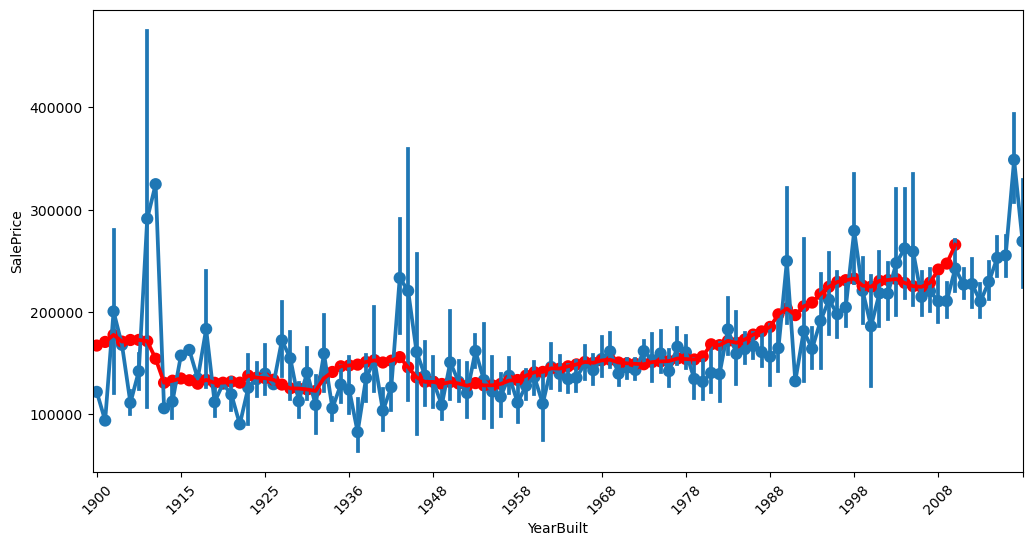

In [57]:
# revise the plot to show rolling mean of housing price every 10 years
var = 'YearBuilt'
fig, ax = plt.subplots(figsize=(12, 6))
data_rolling = data.groupby(var)['SalePrice'].mean().rolling(10).mean().reset_index().dropna()
sns.pointplot(x=var, y="SalePrice", data=data, ci=95,
              ax = ax)
# add the rolling mean
sns.pointplot(x=var, 
              y="SalePrice", 
              data=data_rolling, 
              ci=95, 
              color='red', 
              ax=ax)
plt.xticks(np.arange(0, len(data[var].unique()), 10), rotation=45)
# can anyone find a problem of this plot?

### Correlation Matrixs

<Axes: >

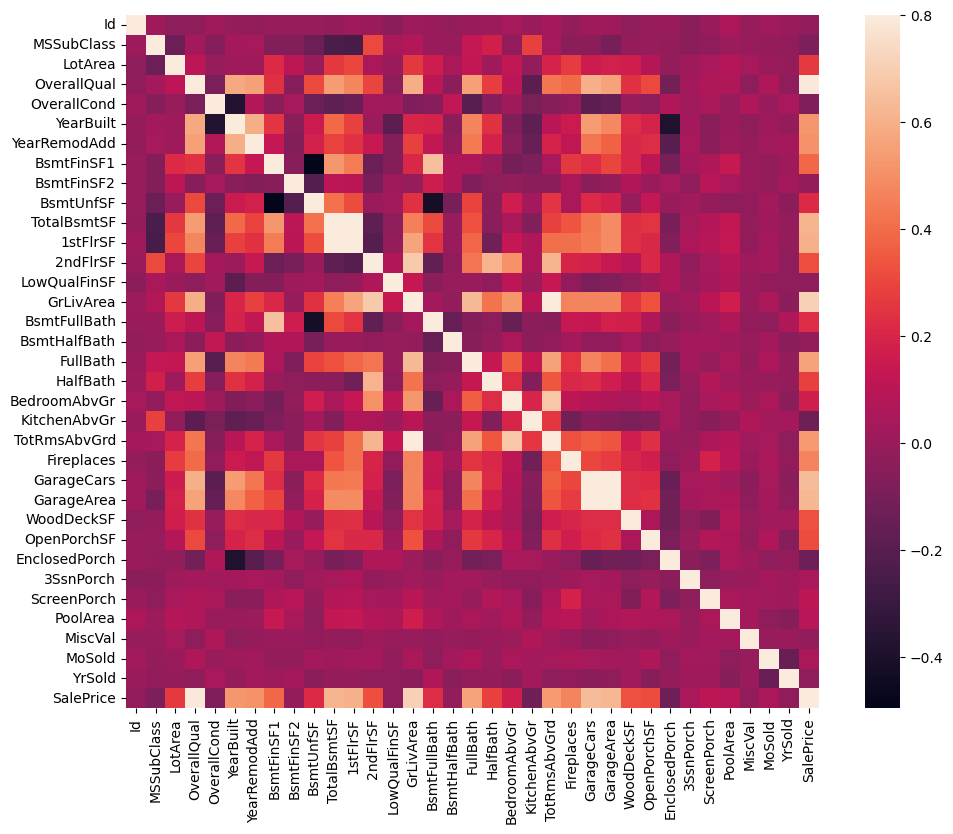

In [59]:
corrmat = df_train[numeric['index'].values].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
# Again, what is the problem in this plot?

<Axes: >

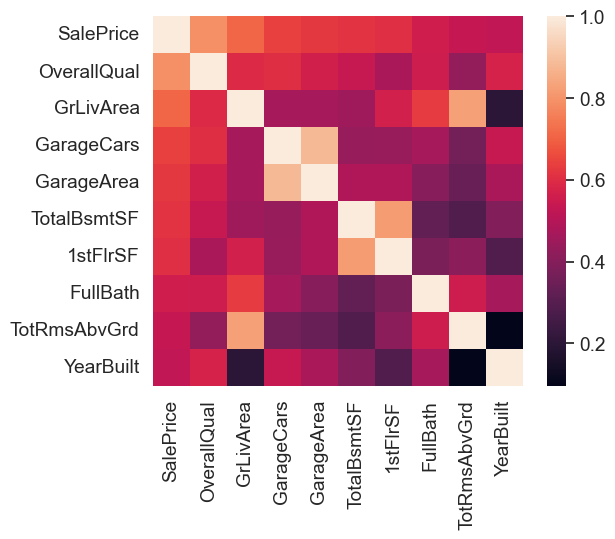

In [69]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = df_train[cols].corr()
# sns.set(font_scale=1.25)
sns.heatmap(cm, 
                 cbar=True, 
                #  annot=True, 
                 square=True, 
                 fmt='.2f',
                 annot_kws={'size': 10}, 
                 yticklabels=cols.values, 
                 xticklabels=cols.values
                 )
# plt.show()

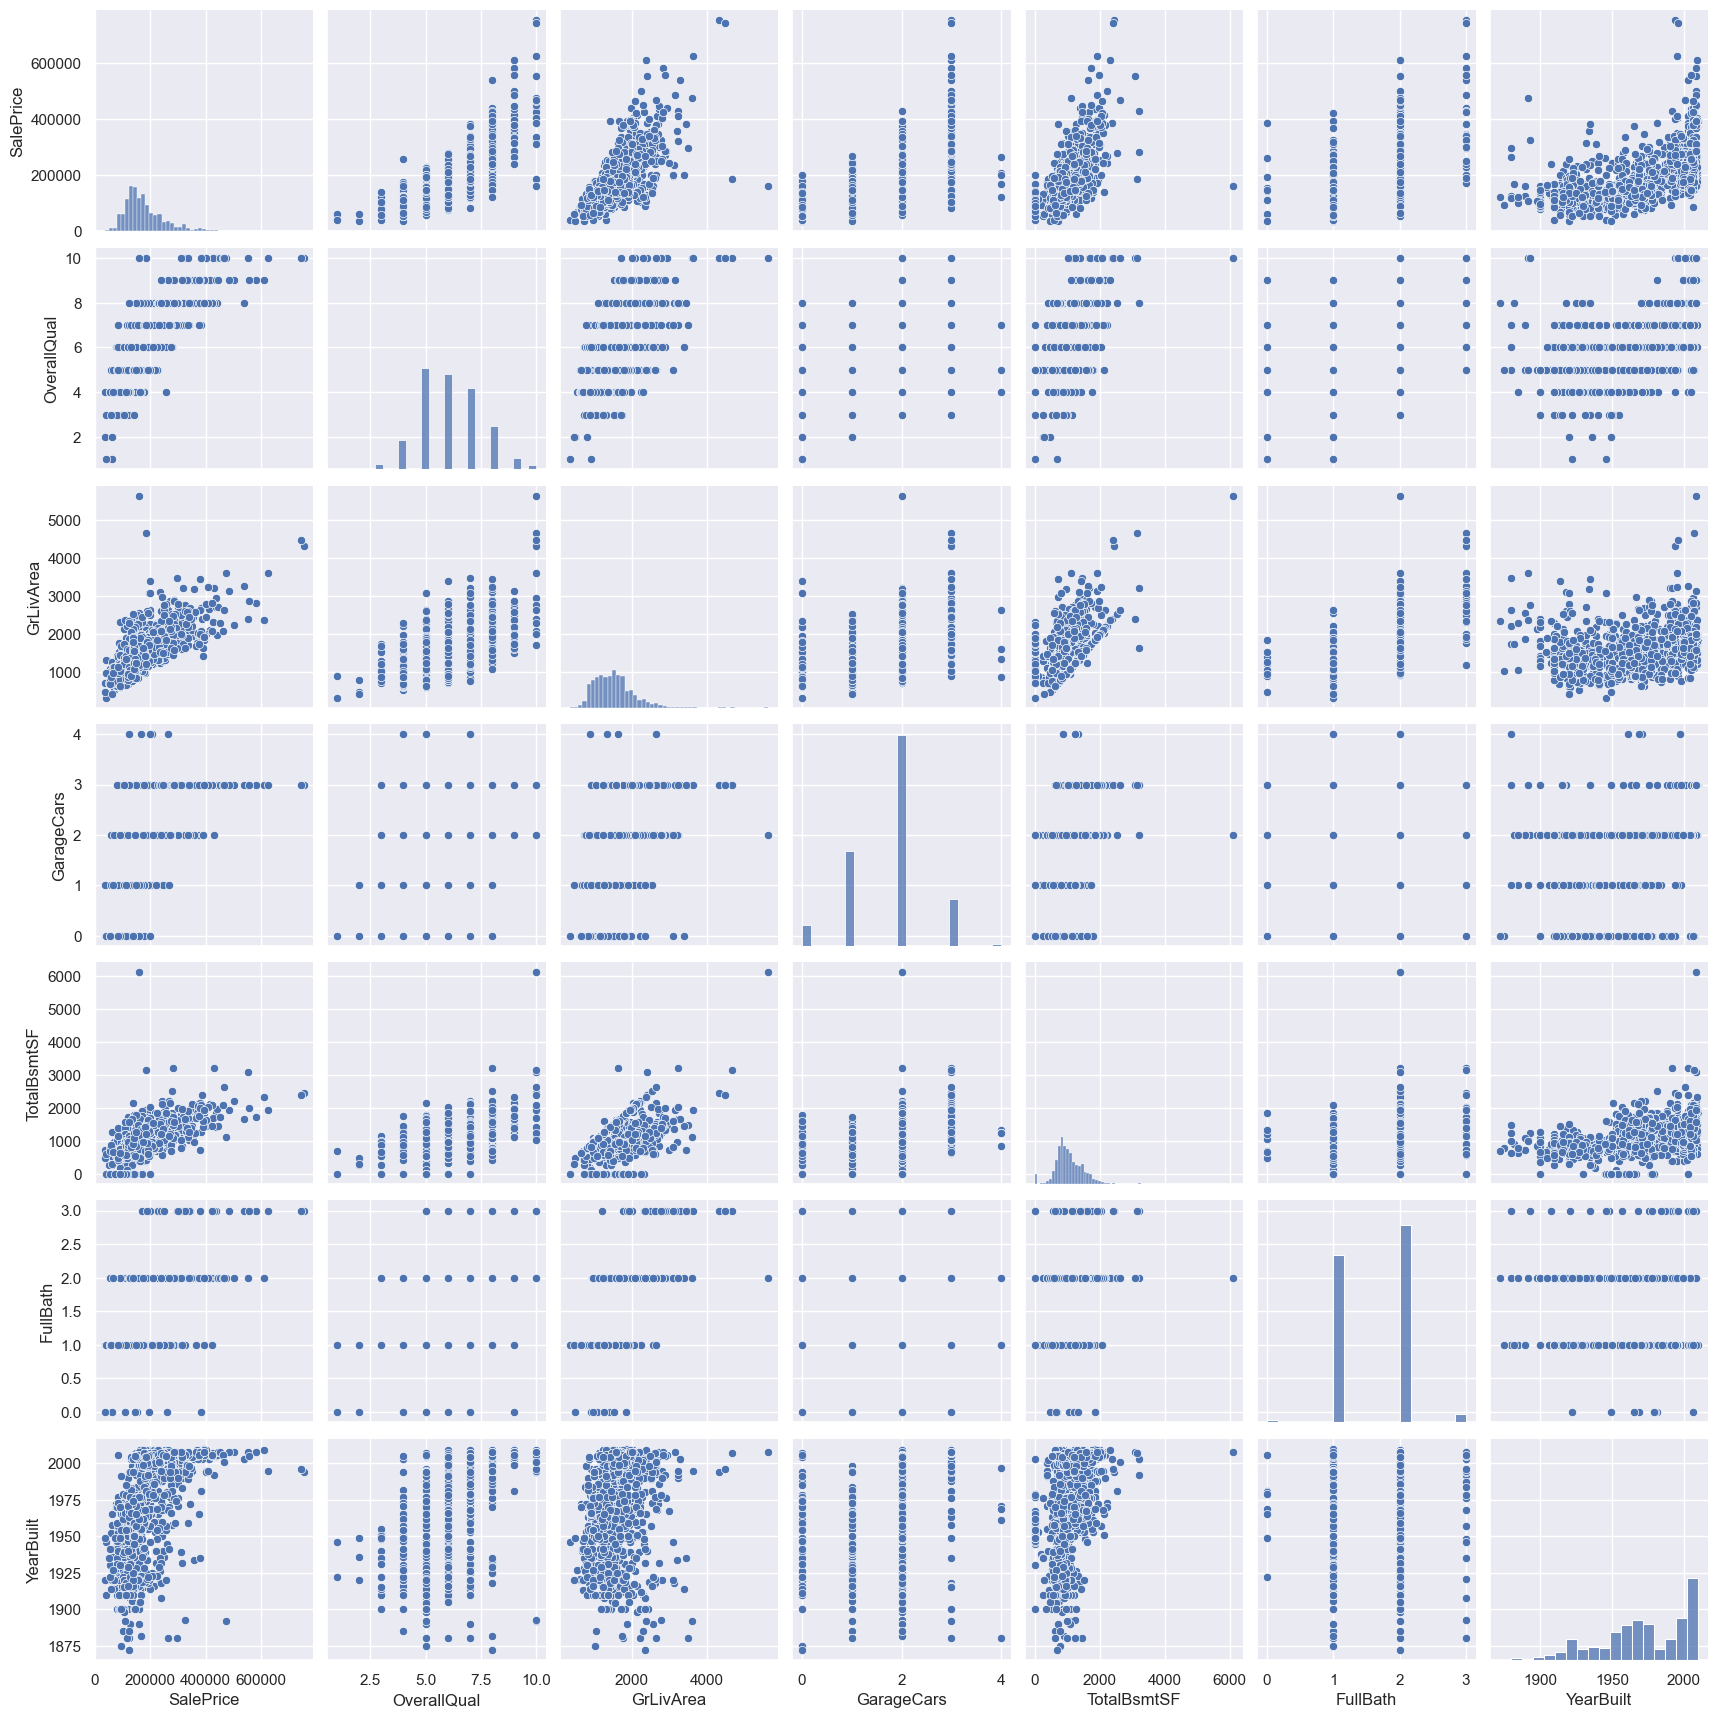

In [70]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();